# Basic Concepts and Prototyping

## Example Model and toy data

model PEAK3

J0: B -> A; J0_Vmax*B/(J0_Km + B)
J1: A -> B; J1_Vmax*A/(J1_Km + A)

# State variables in the system
B=0
A=100

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10

end


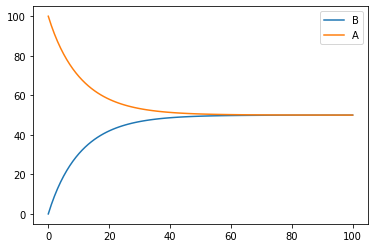

[  0.           1.01010101   2.02020202   3.03030303   4.04040404
   5.05050505   6.06060606   7.07070707   8.08080808   9.09090909
  10.1010101   11.11111111  12.12121212  13.13131313  14.14141414
  15.15151515  16.16161616  17.17171717  18.18181818  19.19191919
  20.2020202   21.21212121  22.22222222  23.23232323  24.24242424
  25.25252525  26.26262626  27.27272727  28.28282828  29.29292929
  30.3030303   31.31313131  32.32323232  33.33333333  34.34343434
  35.35353535  36.36363636  37.37373737  38.38383838  39.39393939
  40.4040404   41.41414141  42.42424242  43.43434343  44.44444444
  45.45454545  46.46464646  47.47474747  48.48484848  49.49494949
  50.50505051  51.51515152  52.52525253  53.53535354  54.54545455
  55.55555556  56.56565657  57.57575758  58.58585859  59.5959596
  60.60606061  61.61616162  62.62626263  63.63636364  64.64646465
  65.65656566  66.66666667  67.67676768  68.68686869  69.6969697
  70.70707071  71.71717172  72.72727273  73.73737374  74.74747475
  75.7575757

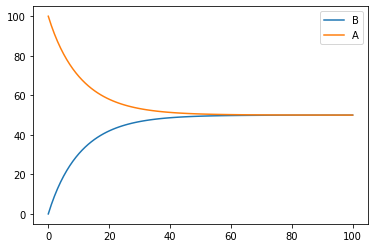

In [1]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

import matplotlib.pyplot as plt
import roadrunner


model = ModelBuilder('PEAK3')
model.add_reaction(Reaction(michaelis_menten, ('B',), ('A',)))
model.add_reaction(Reaction(michaelis_menten, ('A',), ('B',)))

print(model.get_antimony_model())

runner = roadrunner.RoadRunner(model.get_sbml_model())
res = runner.simulate(0, 100, 100)


states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()
# runner.plot()

import numpy as np

print(res['time'])

def find_closest_idx(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

print(find_closest_idx(res['time'], 50))

init_states = model.get_state_variables()
for k, v in init_states.items():
    runner[f'[{k}]'] = v

res = runner.simulate(0, 100, 100)
states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

runner.steadyStateSelections = ['A', 'B']
print(runner.getSteadyStateValues())

print(runner.steadyState())

plt.legend()
plt.show()


[[90 30 20  5]
 [92 31 21  4]
 [93 29 26  6]]
[91.66666667 30.         22.33333333  5.        ]
[0.7200823  0.47140452 1.51535352 0.47140452]


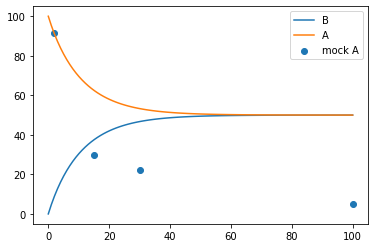

In [2]:
# toy data

import numpy as np

mock_A = [90, 30, 20, 5, 92, 31, 21, 4, 93, 29, 26, 6]
mock_A = np.array(mock_A).reshape(3,4)
mock_A_ave= np.average(mock_A, axis=0)
mock_A_std = np.std(mock_A, axis=0) / np.sqrt(mock_A.shape[0])


print(mock_A)
print(mock_A_ave)
print(mock_A_std)
mock_time = [2, 15, 30, 100]

states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.scatter(mock_time, mock_A_ave, label='mock A')
plt.legend()
plt.show()


## Defining The Objective Function

In [3]:
import roadrunner
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Iterable, Tuple, List

class ExperimentalData:

    '''
    A wrapper for a dict that stores experimental data.
    '''

    def __init__(self):

        self.data = {}

    def add_data(self, time: Iterable, value: Iterable, std_error: Iterable, name: str):

        '''
        Add experimental data to the dict.
        '''

        assert len(time) == len(value) == len(std_error), 'time, value, and std_error must have the same length'

        if name in self.data:
            raise ValueError(f'Experimental data with name {name} already exists')

        self.data[name] = {'time': time, 'value': value, 'std_error': std_error}

    def get_names(self) -> List[str]:

        '''
        Get the names of the experimental data.
        '''

        return list(self.data.keys())

    def get_data(self, name: str) -> Dict:

        '''
        Get experimental data from the dict.
        '''

        if name not in self.data:
            raise ValueError(f'Experimental data with name {name} does not exist')

        return self.data[name]

    def get_data_tuple(self, name: str) -> Tuple[Iterable, Iterable, Iterable]:

        '''
        Get experimental data from the dict as a tuple.
        '''

        if name not in self.data:
            raise ValueError(f'Experimental data with name {name} does not exist')

        return self.data[name]['time'], self.data[name]['value'], self.data[name]['std_error']


def find_closest_idx(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx


def objective(p, 
        model: roadrunner.RoadRunner, 
        params: list, 
        init_state_vars: dict, 
        experimental_data: ExperimentalData, 
        sim_time=100, 
        exp_start_time=1440) -> np.array:
    
    # update parameters
    i = 0 
    while i < len(params):
        parameter, value = params[i], p[i]
        model.model[f'{parameter}'] = value
        i += 1

    # update initial state variables
    for k, value in init_state_vars.items():
        model.model[f'[{k}]'] = value
    
    model.integrator.relative_tolerance = 1e-8
    model.integrator.absolute_tolerance = 1e-8
    # simulate model
    try: 
        res = model.simulate(0, sim_time, sim_time)

    except Exception as e:
        # penalize gravely if simulation fails
        return 1e10

    # calculate objective
    j = 0
    for experimental_state in experimental_data.get_names():
        time, value, std_error = experimental_data.get_data_tuple(experimental_state)
        i = 0 
        while i < len(time):
            t, v, s = time[i], value[i], std_error[i]
            idx = np.argmin(np.abs(res['time'] - t)) # find closest index in sim time array compared to experimental time 
            model_value = res[f'[{experimental_state}]'][idx]
            objective_value = (model_value - v) / s
            j += objective_value ** 2
            i += 1 


    return j


In [4]:
# test objective function

from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

import matplotlib.pyplot as plt
import roadrunner
import numpy as np


model = ModelBuilder('PEAK3')
model.add_reaction(Reaction(michaelis_menten, ('B',), ('A',)))
model.add_reaction(Reaction(michaelis_menten, ('A',), ('B',)))

print(model.get_antimony_model())

runner = roadrunner.RoadRunner(model.get_sbml_model())

mock_A = [90, 30, 20, 5, 92, 31, 21, 4, 93, 29, 26, 6]
mock_A = np.array(mock_A).reshape(3,4)
mock_A_ave= np.average(mock_A, axis=0)
mock_A_std = np.std(mock_A, axis=0) / np.sqrt(mock_A.shape[0])
mock_time = [2, 15, 30, 100]

exp_data = ExperimentalData()
exp_data.add_data(mock_time, mock_A_ave, mock_A_std, 'A')

init_paramset = tuple(model.get_parameters().values())
init_states = model.get_state_variables()
params_name = list(model.get_parameters().keys())

print(params_name)
print(init_paramset)

known_err_array = [0,0,0,0]

print(objective(init_paramset, runner, params_name, init_states, exp_data, sim_time=100))

for i in range(1000):
    objective(init_paramset, runner, params_name, init_states, exp_data, sim_time=100)


model PEAK3

J0: B -> A; J0_Vmax*B/(J0_Km + B)
J1: A -> B; J1_Vmax*A/(J1_Km + A)

# State variables in the system
B=0
A=100

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10

end
['J0_Km', 'J0_Vmax', 'J1_Km', 'J1_Vmax']
(100, 10, 100, 10)
14238.004942693451


## Global Optimization using Scipy.differential_evolution

In [5]:
from scipy.optimize import rosen, differential_evolution
bounds = [(0, 2), (0, 2), (0, 2), (0, 2), (0, 2)]
result = differential_evolution(rosen, bounds, updating='deferred', workers=1)
print(result.x, result.fun)


[1. 1. 1. 1. 1.] 0.0


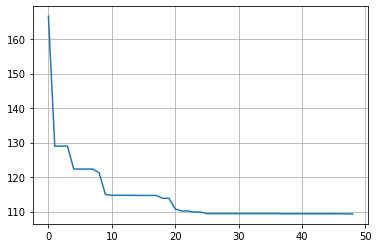

In [6]:
from scipy.optimize import rosen, differential_evolution
from joblib import Parallel, delayed, cpu_count
import sys

def create_bounds(params: list):
    bounds = []
    for param in params:
        bounds.append((param/10, param*10))
    return bounds


def progress_bar(current, total, iteration, current_best, bar_length=50):
    fraction = current / total
    if fraction > 1:
        fraction = 1

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    ending = '\n' if current == total else '\r'

    print(f'Cost: {current_best} Progress: [{arrow}{padding}] {int(fraction*100)}% Current generation: {iteration}', end=ending)

progress_err = []
def callback(x, convergence):
    current_best = objective(x, runner, params_name,
                             init_states, exp_data, sim_time=100)
    progress_err.append(current_best)
    progress_bar(convergence, 1, len(progress_err), current_best)
    # print(f'Error so far: {current_best}, convergence {convergence}', end='\r')
    # sys.stdout.flush()

bounds = create_bounds(init_paramset)

result = differential_evolution(objective, bounds, popsize=100, maxiter=500, 
        args=(runner, params_name, init_states, exp_data, 100), callback=callback)

plt.plot(progress_err)
plt.grid()
plt.show()



In [7]:
# parallel computing for multiple GA runs

n = 10


def parallel_loop(i):
    result = differential_evolution(objective, bounds, popsize=100, tol=0.01, maxiter=50, args=(
        runner, params_name, init_states, exp_data, 100), callback=callback)
    return (result.x, result.fun)


all_paramset = Parallel(n_jobs=cpu_count())(
    delayed(parallel_loop)(i) for i in range(n))


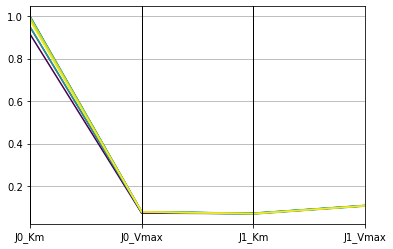

In [8]:
import pandas as pd
paramset_dict = {}
obj_list = []
paramset_list = []
for i in range(len(all_paramset)):
    paramset, obj = all_paramset[i]
    paramset_list.append(paramset)
    obj_list.append(obj)

paramset_list = np.array(paramset_list)

paramset_dict['error'] = obj_list
for i in range(len(params_name)):
    paramset_dict[params_name[i]] = paramset_list[:,i]

df = pd.DataFrame(paramset_dict)

def generate_min_and_max_bound(bounds, params_name):
    min_bound = {}
    max_bound = {}
    for i, p in enumerate(params_name):
        min_bound[p] = bounds[i][0]
        max_bound[p] = bounds[i][1]
    
    return min_bound, max_bound

pdf_min, pdf_max = generate_min_and_max_bound(bounds, params_name)


def normalize(df: pd.DataFrame, pdf_min, pdf_max):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != 'error':
            max_value = pdf_max[feature_name]
            min_value = pdf_min[feature_name]
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

normalized_df = normalize(df, pdf_min, pdf_max)

pd.plotting.parallel_coordinates(normalized_df, 'error', colormap='viridis')

plt.gca().legend_.remove()


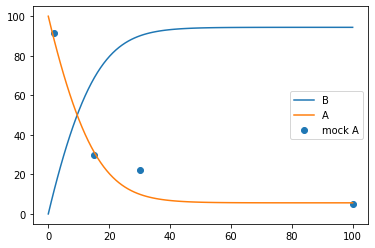

In [9]:
params_name = list(model.get_parameters().keys())

best_fit_df = df[df['error'] == df['error'].min()]
best_fit = best_fit_df.iloc[0].to_numpy()[1:]

for i in range(len(params_name)):
    runner.model[f'{params_name[i]}'] = best_fit[i]
    # print(runner.model[f'{params_name[i]}'])
    
init_states = model.get_state_variables()
for k, v in init_states.items():
    runner[f'[{k}]'] = v

res = runner.simulate(0, 100, 100)
states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)


# print(res)
plt.scatter(mock_time, mock_A_ave, label='mock A')

# plt.scatter(mock_time, mock_A[0,:], label='mock A')
# plt.scatter(mock_time, mock_A[1,:], label='mock A')
# plt.scatter(mock_time, mock_A[2,:], label='mock A')
plt.legend()
plt.show()


In [10]:
import plotly.express as px
import plotly.graph_objects as go


def construct_dimensions(df):
    dimensions = []
    for feature_name in df.columns:
        if feature_name != 'error':
            dimensions.append(
                dict(range=[0, 1], label=feature_name, values=df[feature_name]))
    return dimensions

# normalized_df = px.data.tips()
# dimen = construct_dimensions(normalized_df)
# fig = go.Figure(data=go.Parcoords(dimensions=dimen))


fig = go.Figure(data=go.Parcoords(line=dict(
    color=normalized_df['error'], colorscale=px.colors.sequential.Viridis, showscale=True, colorbar=dict(title='Error')), 
    dimensions=construct_dimensions(normalized_df)),
    layout=go.Layout(title='Parallel Coordinates Plot'))


# fig = px.parallel_coordinates(
#     normalized_df, dimensions=params_name, color='error', color_continuous_scale='Viridis')
fig.show()


# Parameter Estimation for a simple pharmacokinetic model

model testpeak3model

J0: aM -> M; J0_Vmax*aM/(J0_Km + aM)
J1: M -> aM; J1_Vmax*M*egf/(J1_Km + M)
J2: aN -> N; J2_Vmax*aN/(J2_Km + aN)
J3: N -> aN; J3_Vmax*N*aM/(J3_Km + N)

# State variables in the system
aM=0
M=100
aN=0
N=100

# Parameters in the system
egf := piecewise(8.33, time > 600, 0)
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10
J2_Km=100
J2_Vmax=10
J3_Km=100
J3_Vmax=10

# Other variables in the system


end
Roadrunner model compiled and returned


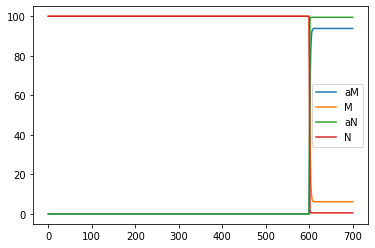

In [1]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

import matplotlib.pyplot as plt
import roadrunner
import numpy as np
import pandas as pd

# Global Variables for the model
stim_time = 600
stim_value = 8.33
global_sim_time = stim_time + 100 
colours = ['#db5f57', '#dbc257', '#91db57', '#57db80',
           '#57d3db', '#5770db', '#a157db', '#db57b2']

model = ModelBuilder('testpeak3model')
model.add_reaction(Reaction(michaelis_menten, ('aM',), ('M',)))
model.add_reaction(Reaction(michaelis_menten_stim, ('M',), ('aM',), extra_states=('egf',)))

model.add_reaction(Reaction(michaelis_menten, ('aN',), ('N',)))
model.add_reaction(Reaction(michaelis_menten_stim, ('N',), ('aN',), extra_states=('aM',)))

model.inject_antimony_string_at(f"egf := piecewise({stim_value}, time > {stim_time}, 0)", 'parameters')

print(model.get_antimony_model())

sbml_model = model.get_sbml_model()

rr = model.get_roadrunner_model(sbml_model)

rr.reset() # Important to always reset model before simulation
res = rr.simulate(0, global_sim_time, global_sim_time, selections=model.get_all_variables_keys(with_time=True))

# print(res)

states = model.get_all_variables_keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'{s}'], label=s)

plt.legend()
plt.show()


## Load in mock experimental data 

Data should be loaded in a .csv format from pandas. The data should be in the following format:
   experimental_state, replicate_number, time_point, value, 

exp_state and replicate_number are used to infer list construction of the data. 

here, we simply extend the mock time by {stim_time} in the model

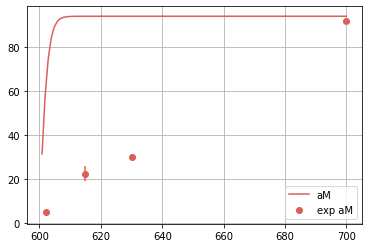

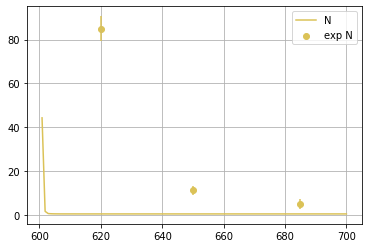

In [3]:
from optimisation.ExpDataLoader import ExpDataLoader as ExperimentalDataHelper

ex = ExperimentalDataHelper()
ex.load_data('example/example_data.csv', delimiter='\t')
# print(ex.get_data())
# states = model.get_state_variables().keys()
# for s in states:
#     # print(s)
#     plt.plot(res['time'], res[f'[{s}]'], label=s)

# # plt.scatter(mock_time_added, mock_A_ave, label='mock aM', color='orange')
# plt.legend()
# plt.show()

# alternatively, plot only after stimulation time
# compare M with mock M data

def plot_state_with_exp_data(exp_state: str, sim_result, mock_time, mock_data, mock_data_std, stim_time, color='blue'):
    plt.plot(sim_result['time'][stim_time:], sim_result[f'{exp_state}'][stim_time:], label=exp_state, color=color)
    plt.scatter(mock_time, mock_data, label=f'exp {exp_state}', color=color)
    plt.errorbar(mock_time, mock_data, yerr=mock_data_std, fmt='none', color=color)
    plt.grid()
    plt.legend()
    plt.show()



# define toy data for aN, assume different mock_time

# alternatively, plot only after stimulation time
# compare M with mock M data
exp_states = ex.get_experimental_states()
for i,s in enumerate(exp_states):
    exp_data = ex.get_state_average_for_each_time_point(s)
    exp_data_std = ex.get_state_std_for_each_time_point(s)
    exp_time = ex.get_state_modified_time(s, stim_time)

    # print(np.array(exp_data))
    # print(np.array(exp_data_std))
    # print(np.array(exp_time))
    plot_state_with_exp_data(s, res, exp_time, exp_data, exp_data_std, stim_time, color=colours[i])


## Define the objective function

In [28]:
from optimisation.DataHelper import DataHelper



def objective(p, 
        model: roadrunner.RoadRunner, 
        params: list, 
        obs_state_vars: list, 
        data_helper: DataHelper, 
        stim_time: float,
        sim_time: float) -> np.array:
    
    # update parameters
    i = 0 
    while i < len(params):
        parameter, value = params[i], p[i]
        model.model[f'{parameter}'] = value
        i += 1
    
    # simulate model
    try: 
        model.reset()
        res = model.simulate(0, sim_time, sim_time, selections=obs_state_vars)

        # some basic error handling 
        for s in obs_state_vars: 
            if s != 'time': 
                # this rule checks for steady state of the model
                delta1 = res[s][stim_time-1] 
                delta2 = res[s][stim_time-10]
                if delta2 != 0 and delta1 != 0: 
                    if np.abs(delta1/delta2) > 1.01: 
                        return 1e10 

                # ensure no negative values in the model 
                if (res[s]<0).any(): 
                    return 1e10


    except Exception as e:
        # penalize gravely if simulation fails
        # print(e)
        return 1e10

    data_helper.match_sim_data(res)
    exp_std, exp_val, sim_val = data_helper.get_data_for_optimisation()

    # print(exp_std)
    # print(exp_val)
    # np.set_printoptions(precision=2, suppress=True)
    # print(sim_val)

    # calculate objective
    sj = (exp_val - sim_val) / exp_std
    obj = np.sum(sj*sj)
    return obj

# vectorised objective function
def objective_vec(p: np.array,
              model: roadrunner.RoadRunner,
              params: list,
              init_state_vars: dict,
              data_helper: DataHelper,
              sim_time=200) -> np.array:

    # print(p.shape)
    
    try: 
        size_zero = p.shape[1]
    except IndexError:
        size_zero = 1

    all_std = np.ones((size_zero,data_helper.total_size))
    all_exp = np.ones((size_zero,data_helper.total_size))
    all_sim = np.ones((size_zero,data_helper.total_size))

    if size_zero == 1: 
        i = 0
        while i < len(params):
            parameter, value = params[i], p[i]
            model.model[f'{parameter}'] = value
            i += 1

        # update initial state variables
        for k, value in init_state_vars.items():
            model.model[f'[{k}]'] = value

        # simulate model
        try:
            res = model.simulate(0, sim_time, sim_time)

        except Exception as e:
            # penalize gravely if simulation fails
            return 1e10

        data_helper.match_sim_data(res)
        exp_std, exp_val, sim_val = data_helper.get_data_for_optimisation()

        # calculate objective
        sj = (exp_val - sim_val) / exp_std
        obj = np.sum(sj*sj)
        return obj

    j = 0 
    while j < p.shape[1]:
        pi = p[:, j]

        # update parameters
        i = 0
        while i < len(params):
            parameter, value = params[i], pi[i]
            model.model[f'{parameter}'] = value
            i += 1

        # update initial state variables
        for k, value in init_state_vars.items():
            model.model[f'[{k}]'] = value

        # simulate model
        try:
            res = model.simulate(0, sim_time, sim_time)

        except Exception as e:
            # penalize gravely if simulation fails
            res = None

        if res is not None:
            data_helper.match_sim_data(res)
            exp_std, exp_val, sim_val = data_helper.get_data_for_optimisation()
            all_std[j,:] = exp_std
            all_exp[j,:] = exp_val
            all_sim[j,:] = sim_val
        
        else: 
            all_std[j,:] = np.ones(data_helper.total_size) * 1e10
            all_exp[j,:] = np.ones(data_helper.total_size) * 1e10
            all_sim[j,:] = np.ones(data_helper.total_size) * 1e10

        j += 1 


    # np.set_printoptions(precision=2, suppress=True)

    # print(all_exp)
    # print(all_sim)
    # print(all_std)

    # calculate objective
    sj = (all_exp - all_sim) / all_std
    obj = np.sum(sj*sj, axis=1)
    # print(obj.shape)
    return obj


### Testing the objective function

In [29]:
# test objective function

exp_data = DataHelper()
for s in ex.get_experimental_states():
    exp_data.add_exp_data(ex.get_state_modified_time(s, stim_time), ex.get_state_average_for_each_time_point(s), ex.get_state_std_for_each_time_point(s), s)
    

init_paramset = tuple(model.get_parameters().values())
init_states = model.get_state_variables()
params_name = list(model.get_parameters().keys())
obs_state_vars = model.get_all_variables_keys(with_time=True)

print(params_name)
print(init_paramset)

known_err_array = [0,0,0,0]

vec_paramset = np.ones((len(init_paramset), 3))
j = 0
while j < vec_paramset.shape[1]:
    vec_paramset[:,j] = init_paramset
    j += 1

print(objective(init_paramset, rr, params_name, obs_state_vars, exp_data, stim_time ,sim_time=global_sim_time))
# print(objective_vec(vec_paramset, rr, params_name, init_states, exp_data,sim_time=global_sim_time))


['J0_Km', 'J0_Vmax', 'J1_Km', 'J1_Vmax', 'J2_Km', 'J2_Vmax', 'J3_Km', 'J3_Vmax']
(100, 10, 100, 10, 100, 10, 100, 10)
7589.689591166783


## Running the optimization

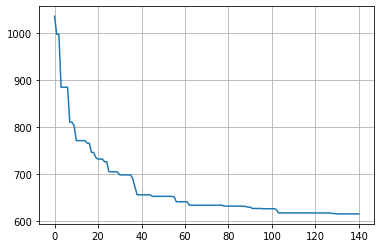

In [30]:
from scipy.optimize import rosen, differential_evolution
import sys
import time
# from roadrunner import Config
# Config.setValue(Config.ROADRUNNER_DISABLE_WARNINGS, True)

def create_bounds(params: list, perturb_size: int) -> list:
    bounds = []
    for param in params:
        bounds.append((param/perturb_size, param*perturb_size))
    return bounds


def progress_bar(current, total, iteration, current_best, elapsed_time, bar_length=30):
    fraction = current / total
    if fraction > 1:
        fraction = 1

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    ending = '\n' if current == total else '\r'

    end_time = time.time()

    print(f'Cost: {current_best:.2f}| Progress: [{arrow}{padding}] {int(fraction*100)}%| Gen: {iteration}| Time per gen (s): {elapsed_time:.3f}', end=ending)

progress_err = []
start_time = time.time()

def callback(x, convergence):
    end_time = time.time()
    n = len(progress_err)
    elapsed_time = (end_time - start_time) / n if n > 0 else 0
    current_best = objective(
        x, rr, params_name, obs_state_vars, exp_data, stim_time, global_sim_time)
    progress_err.append(current_best)
    progress_bar(convergence, 1, n, current_best, elapsed_time)
    # print(f'Error so far: {current_best}, convergence {convergence}', end='\r')
    # sys.stdout.flush()

# genetic algorithm parameters
bounds = create_bounds(init_paramset, 5)
pop_size = 15
max_iter = 1000


result = differential_evolution(objective, bounds, popsize=pop_size, maxiter=max_iter,
        args=(rr, params_name, obs_state_vars, exp_data, stim_time ,global_sim_time), callback=callback)

plt.plot(progress_err)
plt.grid()
plt.show()



## Evaluate multiple optimization runs

In [21]:
# parallel computing for multiple GA runs
from joblib import Parallel, delayed, cpu_count

n = 10


def parallel_loop(i):
    result = differential_evolution(objective_vec, bounds, popsize=pop_size, maxiter=max_iter,
            args=(rr, params_name, init_states, exp_data, global_sim_time), callback=callback)
    return (result.x, result.fun)


all_paramset = Parallel(n_jobs=cpu_count())(
    delayed(parallel_loop)(i) for i in range(n))


## Visualise Estimated Parameters

In [22]:
import pandas as pd

# process all_paramset into a dict format to load it onto pandas dataframe
paramset_dict = {}
obj_list = []
paramset_list = []
for i in range(len(all_paramset)):
    paramset, obj = all_paramset[i]
    paramset_list.append(paramset)
    obj_list.append(obj)

paramset_list = np.array(paramset_list)

paramset_dict['error'] = obj_list
for i in range(len(params_name)):
    paramset_dict[params_name[i]] = paramset_list[:,i]

df = pd.DataFrame(paramset_dict)

def generate_min_and_max_bound(bounds, params_name):
    min_bound = {}
    max_bound = {}
    for i, p in enumerate(params_name):
        min_bound[p] = bounds[i][0]
        max_bound[p] = bounds[i][1]
    
    return min_bound, max_bound


def normalize(df: pd.DataFrame, pdf_min, pdf_max):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != 'error':
            max_value = pdf_max[feature_name]
            min_value = pdf_min[feature_name]
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

pdf_min, pdf_max = generate_min_and_max_bound(bounds, params_name)
normalized_df = normalize(df, pdf_min, pdf_max)

use_plotly = True
## You can choose two ways to visualise the data, either by parallel coordinate plot via pandas 
## or by using plotly

if use_plotly:
    import plotly.express as px
    import plotly.graph_objects as go


    def construct_dimensions(df):
        # in the future, use pdf_min[feature_name], pdf_max[feature_name] to construct the range of the feature
        # this needs original df values
        dimensions = []
        for feature_name in df.columns:
            if feature_name != 'error':
                dimensions.append(
                    dict(range=[pdf_min[feature_name], pdf_max[feature_name]], label=feature_name, values=df[feature_name]))
        return dimensions


    fig = go.Figure(data=go.Parcoords(line=dict(
        color=normalized_df['error'], colorscale=px.colors.sequential.Bluered, showscale=True, colorbar=dict(title='Error')), 
        dimensions=construct_dimensions(df)),
        layout=go.Layout(title='Parallel Coordinates Plot'))

    fig.show()
else:
    pd.plotting.parallel_coordinates(normalized_df, 'error', colormap='viridis')
    plt.gca().legend_.remove()

## Visualise the fit

[ 83.46730597   2.00289669 499.89343449   2.00127463  22.88885258
   3.96366539 493.93353107   2.00663918]


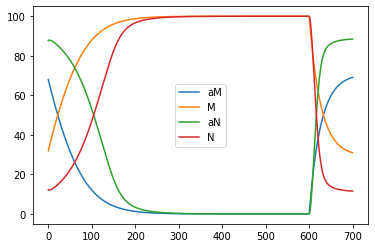

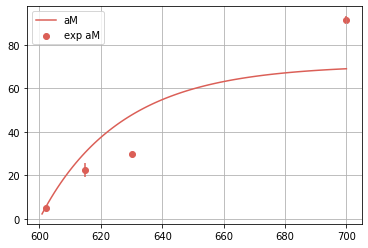

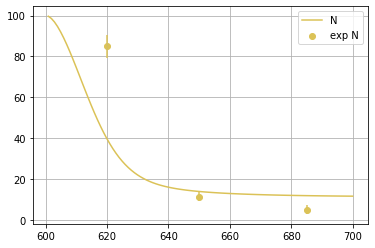

In [27]:
params_name = list(model.get_parameters().keys())

best_fit_df = df[df['error'] == df['error'].min()]
best_fit = best_fit_df.iloc[0].to_numpy()[1:]

print(best_fit)

for i in range(len(params_name)):
    rr.model[f'{params_name[i]}'] = best_fit[i]
    # print(runner.model[f'{params_name[i]}'])


# rr.reset()
res = rr.simulate(0, global_sim_time, global_sim_time)
states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'{s}'], label=s)

plt.legend()
plt.show()

exp_states = ex.get_experimental_states()
for i,s in enumerate(exp_states):
    exp_data = ex.get_state_average_for_each_time_point(s)
    exp_data_std = ex.get_state_std_for_each_time_point(s)
    exp_time = ex.get_state_modified_time(s, stim_time)

    # print(np.array(exp_data))
    # print(np.array(exp_data_std))
    # print(np.array(exp_time))
    plot_state_with_exp_data(s, res, exp_time, exp_data, exp_data_std, stim_time, color=colours[i])


# Evaluating the PEAK3 model(s) 

In [1]:
### Global Variables

# Global Variables for the model
stim_time = 600
stim_value = 8.33
global_sim_time = stim_time + 180
colours = ['#db5f57', '#dbc257', '#91db57', '#57db80',
           '#57d3db', '#5770db', '#a157db', '#db57b2']

### Model import from models/peak3

In [2]:
### Here, we use pickle to import pre-constructed peak3 models from model_construction.ipynb
import pickle
from models.ModelBuilder import ModelBuilder

peak3_model: ModelBuilder = pickle.load(open('models\\peak3\\peak3_model.pkl', 'rb'))

print(peak3_model.head())
# print(peak3_model.get_antimony_model())

Model Name peak3model
Number of Reactions 26
Number of State Variables 18
Number of Parameters 36
Number of Custom Variables 6
Number of Enforced State Values 7
Number of Custom Strings 0



#### Compile model to sbml and perform test simulations

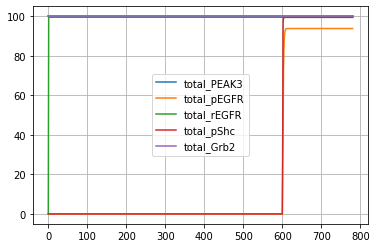

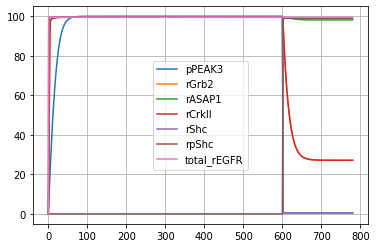

In [3]:
import roadrunner 
import matplotlib.pyplot as plt

sbml = peak3_model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)
rr.integrator.relative_tolerance = 1e-8
rr.integrator.absolute_tolerance = 1e-8
rr.integrator.nonnegative = True

states = peak3_model.get_all_variables_keys()
custom_states = peak3_model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, global_sim_time, global_sim_time, selections=sim_states)

states_no_egf = [s for s in custom_states if s != 'egf']
observable_states = ['pPEAK3', 'rGrb2', 'rASAP1',
                     'rCrkII', 'rShc', 'rpShc', 'total_rEGFR']

for state in states_no_egf:
    plt.plot(res['time'], res[f'{state}'], label=state)

plt.legend()
plt.grid()
plt.show()

for state in observable_states:
    plt.plot(res['time'], res[f'{state}'], label=state)

plt.legend()
plt.grid()
plt.show()

### Load in experimental data

NOTE: Code block must be ran above to obtain simulation results

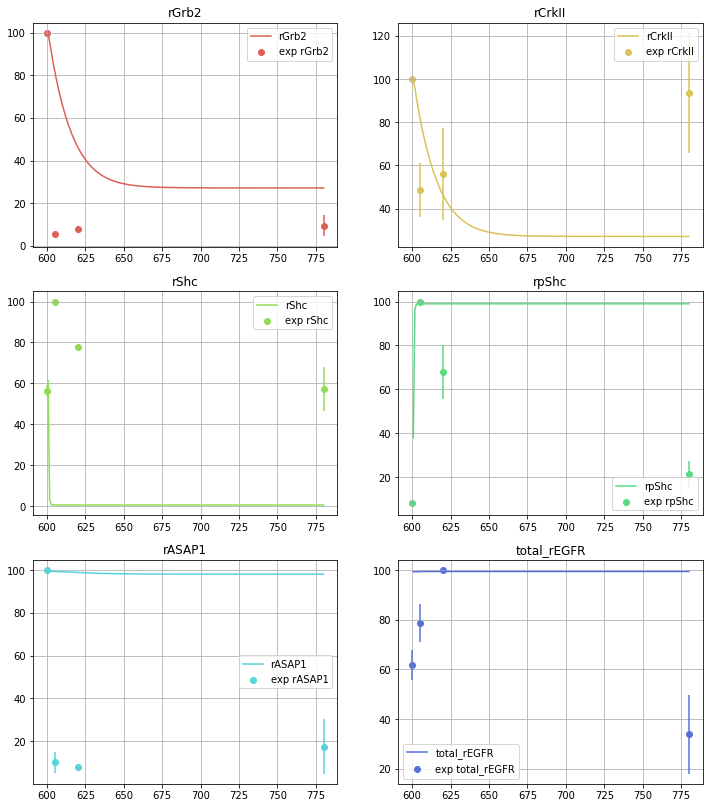

In [4]:
from optimisation.ExpDataLoader import ExpDataLoader
import numpy as np

ex = ExpDataLoader()
ex.load_data('data\\peak3_data.csv', delimiter='\t')


def plot_state_with_exp_data(exp_state: str, sim_result, mock_time, mock_data, mock_data_std, stim_time, color='blue'):
    plt.plot(sim_result['time'][stim_time:], sim_result[f'{exp_state}'][stim_time:], label=exp_state, color=color)
    plt.scatter(mock_time, mock_data, label=f'exp {exp_state}', color=color)
    plt.errorbar(mock_time, mock_data, yerr=mock_data_std, fmt='none', color=color)
    plt.grid()
    plt.legend()
    plt.show()

def plot_state_with_exp_data_subplot(i, j, exp_state: str, sim_result, mock_time, mock_data, mock_data_std, stim_time, color='blue'):
    axis[i,j].plot(sim_result['time'][stim_time:], sim_result[f'{exp_state}'][stim_time:], label=exp_state, color=color)
    axis[i,j].scatter(mock_time, mock_data, label=f'exp {exp_state}', color=color)
    axis[i,j].errorbar(mock_time, mock_data, yerr=mock_data_std, fmt='none', color=color)
    axis[i,j].set_title(exp_state)
    axis[i,j].grid()
    axis[i,j].legend()
    # axis[i,j].show()


fig_i, fig_j = 3, 2
figure, axis = plt.subplots(fig_i, fig_j, figsize=(12, 14))
figure_start_time = 600
exp_states = ex.get_experimental_states()
for i,s in enumerate(exp_states):
    exp_data = ex.get_state_average_for_each_time_point(s)
    exp_data_std = ex.get_state_std_for_each_time_point(s)
    exp_time = ex.get_state_modified_time(s, stim_time)

    fi = i // fig_j
    fj = i % fig_j
    # print(fi, fj)
    # print('Exp Data Ave', np.array(exp_data))
    # print('Exp Data Std',np.array(exp_data_std))
    # print('Exp Data Timepoints', np.array(exp_time))
    # plot_state_with_exp_data(s, res, exp_time, exp_data, exp_data_std, stim_time, color=colours[i])
    plot_state_with_exp_data_subplot(fi, fj, s, res, exp_time, exp_data, exp_data_std, figure_start_time, color=colours[i])


### Define and test Objective Function

In [18]:
from optimisation.DataHelper import DataHelper

def objective(p, 
        model: roadrunner.RoadRunner, 
        params: list, 
        obs_state_vars: list, 
        data_helper: DataHelper, 
        stim_time: float,
        sim_time: float) -> np.array:
    
    # update parameters
    i = 0 
    while i < len(params):
        parameter, value = params[i], p[i]
        model.model[f'{parameter}'] = value
        i += 1
    
    # simulate model
    try: 
        model.reset()
        res = model.simulate(0, sim_time, sim_time, selections=obs_state_vars)

        # some basic error handling 
        for s in obs_state_vars: 
            if s != 'time': 
                # this rule checks for steady state of the model
                delta1 = res[s][stim_time-1] 
                delta2 = res[s][stim_time-10]
                if delta2 != 0 and delta1 != 0: 
                    if np.abs(delta1/delta2) > 1.01: 
                        # print('FAILED to converge to steady state', s, delta1, delta2)
                        return 1e10 

                # ensure no negative values in the model 
                if (res[s]<0).any(): 
                    # print('FAILED to have non-negative values', s, res[s])
                    return 1e10

    except Exception as e:
        # penalize gravely if simulation fails
        # print(e)
        return 1e10

    data_helper.match_sim_data(res)
    exp_std, exp_val, sim_val = data_helper.get_data_for_optimisation()

    # print(exp_std)
    # print(exp_val)
    # np.set_printoptions(precision=2, suppress=True)
    # print(sim_val)

    # calculate objective
    if (exp_std==0).any():
        # then we demand high precision of that state
        exp_std = np.where(exp_std==0, 1, exp_std)
    sj = (exp_val - sim_val) / exp_std
    obj = np.sum(sj*sj)
    return obj

In [19]:
### Quick Test for obj func

exp_data = DataHelper()
model = peak3_model
for s in ex.get_experimental_states():
    exp_data.add_exp_data(ex.get_state_modified_time(
        s, stim_time), ex.get_state_average_for_each_time_point(s), ex.get_state_std_for_each_time_point(s), s)


init_paramset = tuple(model.get_parameters().values())
init_states = model.get_state_variables()
params_name = list(model.get_parameters().keys())
obs_state_vars = model.get_all_variables_keys(with_time=True)

print(params_name)
print(init_paramset)

print(objective(init_paramset, rr, params_name, obs_state_vars,
      exp_data, stim_time, sim_time=global_sim_time))


['cr1_Km', 'cr1_Vmax', 'cr2_Km', 'cr2_Vmax', 'cr3_Km', 'cr3_Vmax', 'cr4_Km', 'cr4_Vmax', 'core1_Km', 'core1_Vmax', 'core1b_Km', 'core1b_Vmax', 'cr5_Km', 'cr5_Vmax', 'cr6_Km', 'cr6_Vmax', 'cr7_Km', 'cr7_Vmax', 'cr8_Km', 'cr8_Vmax', 'cr9_Km', 'cr9_Vmax', 'cr10_Km', 'cr10_Vmax', 'cr11_Km', 'cr11_Vmax', 'cr12_Km', 'cr12_Vmax', 'cr13_Km', 'cr13_Vmax', 'cr14_Km', 'cr14_Vmax', 'cr15_Km', 'cr15_Vmax', 'cr16_Km', 'cr16_Vmax']
(100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10, 100, 10)
10000000000.0


### Parameter Estimation

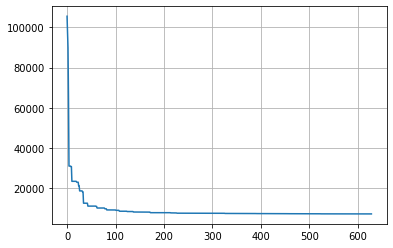

In [20]:
from scipy.optimize import rosen, differential_evolution
import sys
import time

from optimisation.HelperFunctions import *

def progress_bar(current, total, iteration, current_best, elapsed_time, bar_length=30):
    fraction = current / total
    if fraction > 1:
        fraction = 1

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    ending = '\n' if current == total else '\r'

    end_time = time.time()

    print(f'Cost: {current_best:.2f}| Progress: [{arrow}{padding}] {int(fraction*100)}%| Gen: {iteration}| Time per gen (s): {elapsed_time:.3f}', end=ending)

def callback(x, convergence):
    end_time = time.time()
    n = len(progress_err)
    elapsed_time = (end_time - start_time) / n if n > 0 else 0
    current_best = objective(
        x, rr, params_name, obs_state_vars, exp_data, stim_time, global_sim_time)
    progress_err.append(current_best)
    progress_bar(convergence, 1, n, current_best, elapsed_time)
    # print(f'Error so far: {current_best}, convergence {convergence}', end='\r')
    # sys.stdout.flush()

progress_err = []
start_time = time.time()
# genetic algorithm parameters
bounds = create_bounds(init_paramset, 5)
pop_size = 15
max_iter = 1000


result = differential_evolution(objective, bounds, popsize=pop_size, maxiter=max_iter,
        args=(rr, params_name, obs_state_vars, exp_data, stim_time ,global_sim_time), callback=callback)

plt.plot(progress_err)
plt.grid()
plt.show()

### Visualisation of the fit and estimated parameters

In [ ]:
# Visualise the single GA run for troubleshooting

[394.3195349   34.35150644  20.81045471  48.47059108 190.04397538
  31.0633583  243.07694581  12.90604987  20.40789966   3.73796587
 166.86589294   6.54080226  20.30826921  49.77218544 472.4874781
   2.00218963 170.78544918   4.41340593  64.84740436  40.94290576
 366.80455708  15.84878443  21.16758829  49.95057436 157.49004057
  19.73508345  24.72506919  40.16906638 232.79563691  16.54324585
 490.87471542  25.96424369  61.3124217   41.12272252 104.45951486
  39.76218974]


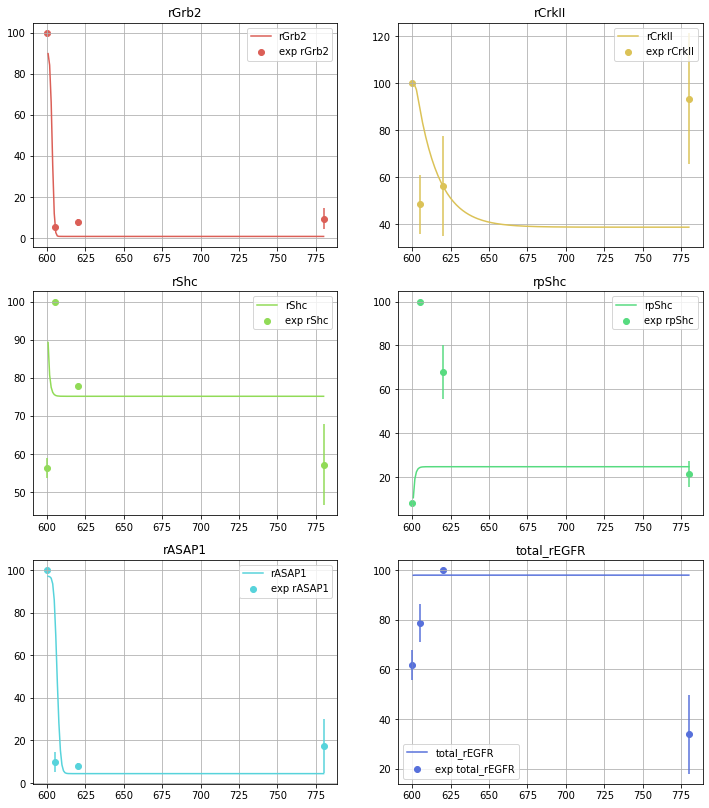

In [21]:
best_fit = result.x

print(best_fit)

for i in range(len(params_name)):
    rr.model[f'{params_name[i]}'] = best_fit[i]

rr.reset()
res = rr.simulate(0, global_sim_time, global_sim_time, selections=obs_state_vars)

fig_i, fig_j = 3, 2
figure, axis = plt.subplots(fig_i, fig_j, figsize=(12, 14))
figure_start_time = 600
exp_states = ex.get_experimental_states()
for i,s in enumerate(exp_states):
    exp_data = ex.get_state_average_for_each_time_point(s)
    exp_data_std = ex.get_state_std_for_each_time_point(s)
    exp_time = ex.get_state_modified_time(s, stim_time)

    fi = i // fig_j
    fj = i % fig_j
    # print(fi, fj)
    # print('Exp Data Ave', np.array(exp_data))
    # print('Exp Data Std',np.array(exp_data_std))
    # print('Exp Data Timepoints', np.array(exp_time))
    # plot_state_with_exp_data(s, res, exp_time, exp_data, exp_data_std, stim_time, color=colours[i])
    plot_state_with_exp_data_subplot(fi, fj, s, res, exp_time, exp_data, exp_data_std, figure_start_time, color=colours[i])


In [ ]:
# parallel computing for multiple GA runs
from joblib import Parallel, delayed, cpu_count

n = 10


def parallel_loop(i):
    result = differential_evolution(objective_vec, bounds, popsize=pop_size, maxiter=max_iter,
                                    args=(rr, params_name, obs_state_vars, exp_data, stim_time, global_sim_time), callback=callback)
    return (result.x, result.fun)


all_paramset = Parallel(n_jobs=cpu_count())(
    delayed(parallel_loop)(i) for i in range(n))


### Save the estimated parameters to allow calibrated model reuse